# We analyze the World Athletics (formerly known as International Association of Athletics Federations - IAAF) 100m and 200m all-time men and women lists # 

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

## Scraping the data from the World Athletics website to build pandas DataFrames ##


### I. Choose the number of pages to include

In [2]:
# choose number of pages of results we want to include from the WA lists (for each gender)
# 0<npage<=17 (17 is the maximum number of pages for men's 200m lists)
npage=17

### II. Scrape the data from the WA website  
(the cell below takes a couple of minutes to evaluate since it's web-scraping all the necessary data)

In [3]:
df_to_concat_100m_list = []
df_to_concat_200m_list = []

# men's 100m and 200m results
# we manually checked that we need element 0 of the output of pd.read_html
ip=1
while ip<=npage:
    one_page_read = pd.read_html('http://www.worldathletics.org/records/all-time-toplists/sprints/100-metres/outdoor/men/senior?page=' + str(ip))
    two_page_read = pd.read_html('http://www.worldathletics.org/records/all-time-toplists/sprints/200-metres/outdoor/men/senior?page=' + str(ip))
    tmp_df_one = one_page_read[0].copy()
    tmp_df_one['Gender'] = 1
    tmp_df_two = two_page_read[0].copy()
    tmp_df_two['Gender'] = 1
    df_to_concat_100m_list.append(tmp_df_one)
    df_to_concat_200m_list.append(tmp_df_two)
    ip+=1
    
# women's 100m and 200m results
ip=1
while ip<=npage:
    one_page_read = pd.read_html('http://www.worldathletics.org/records/all-time-toplists/sprints/100-metres/outdoor/women/senior?page=' + str(ip))
    two_page_read = pd.read_html('http://www.worldathletics.org/records/all-time-toplists/sprints/200-metres/outdoor/women/senior?page=' + str(ip))
    tmp_df_one = one_page_read[0].copy()
    tmp_df_one['Gender'] = 0
    tmp_df_two = two_page_read[0].copy()
    tmp_df_two['Gender'] = 0
    df_to_concat_100m_list.append(tmp_df_one)
    df_to_concat_200m_list.append(tmp_df_two)
    ip+=1

# 100m dataframe
df1 = pd.concat(df_to_concat_100m_list, ignore_index=True) 
df1.rename(columns={'Mark':'100m'}, inplace=True)

# 200m dataframe
df2 = pd.concat(df_to_concat_200m_list, ignore_index=True)
df2.rename(columns={'Mark':'200m'}, inplace=True)

In [4]:
df1.head()

,Rank,100m,WIND,Competitor,DOB,Nat,Pos,Unnamed: 7,Venue,Date,Results Score,Gender
0,1,9.58,0.9,Usain BOLT,21 AUG 1986,JAM,1,NaN,"Olympiastadion, Berlin (GER)",16 AUG 2009,1356,1
1,2,9.69,2.0,Tyson GAY,09 AUG 1982,USA,1,NaN,Shanghai (CHN),20 SEP 2009,1316,1
2,2,9.69,-0.1,Yohan BLAKE,26 DEC 1989,JAM,1,NaN,"Pontaise, Lausanne (SUI)",23 AUG 2012,1316,1
3,4,9.72,0.2,Asafa POWELL,23 NOV 1982,JAM,1f1,NaN,"Pontaise, Lausanne (SUI)",02 SEP 2008,1305,1
4,5,9.74,0.9,Justin GATLIN,10 FEB 1982,USA,1,NaN,"Hamad Bin Suhaim, Doha (QAT)",15 MAY 2015,1298,1


## Data pre-processing

### I. Initial cleaning and checks on the DataFrames

In [5]:
# drop empty column
df1.drop('Unnamed: 7',axis=1, inplace=True)
df2.drop('Unnamed: 7',axis=1, inplace=True)

In [6]:
df1.head()

,Rank,100m,WIND,Competitor,DOB,Nat,Pos,Venue,Date,Results Score,Gender
0,1,9.58,0.9,Usain BOLT,21 AUG 1986,JAM,1,"Olympiastadion, Berlin (GER)",16 AUG 2009,1356,1
1,2,9.69,2.0,Tyson GAY,09 AUG 1982,USA,1,Shanghai (CHN),20 SEP 2009,1316,1
2,2,9.69,-0.1,Yohan BLAKE,26 DEC 1989,JAM,1,"Pontaise, Lausanne (SUI)",23 AUG 2012,1316,1
3,4,9.72,0.2,Asafa POWELL,23 NOV 1982,JAM,1f1,"Pontaise, Lausanne (SUI)",02 SEP 2008,1305,1
4,5,9.74,0.9,Justin GATLIN,10 FEB 1982,USA,1,"Hamad Bin Suhaim, Doha (QAT)",15 MAY 2015,1298,1


In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3400 entries, 0 to 3399
Data columns (total 11 columns):
Rank             3400 non-null int64
100m             3400 non-null float64
WIND             3241 non-null float64
Competitor       3400 non-null object
DOB              3331 non-null object
Nat              3400 non-null object
Pos              3389 non-null object
Venue            3400 non-null object
Date             3400 non-null object
Results Score    3400 non-null int64
Gender           3400 non-null int64
dtypes: float64(2), int64(3), object(6)
memory usage: 292.3+ KB


We see that pandas correctly casted Rank as int64, Mark and WIND as float64, Results Score as int64. There are missing values in the WIND, DOB and Pos columns but this is to be expected. We can check what specific rows those missing values correspond to by running   

*df1[df1['Pos'].isnull()]*   

and so on.

### II. Create 'Age at PB' column on 100m DataFrame (PB=Personal Best)

There will be some NaNs in this column due to the fact that there are some in the DOB column

In [8]:
df1_wa = df1.copy()

df1_wa['Age at PB'] = pd.to_datetime(df1_wa['Date'])-pd.to_datetime(df1_wa['DOB'])
df1_wa['Age at PB'] = df1_wa['Age at PB'].dt.days

# converting from age in days to age in years
df1_wa['Age at PB'] = df1_wa['Age at PB'].apply(lambda ndays: float(ndays/365.25))

### III. Check for outliers

In [9]:
df1_wa.describe()

,Rank,100m,WIND,Results Score,Gender,Age at PB
count,3400.000000,3400.000000,3241.000000,3400.000000,3400.000000,3331.000000
mean,825.063529,10.729409,1.013206,1143.632059,0.500000,23.461422
std,478.829199,0.577220,0.788814,36.088238,0.500074,3.318536
min,1.000000,9.580000,-3.600000,1095.000000,0.000000,14.527036
25%,413.000000,10.200000,0.500000,1116.000000,0.000000,21.223819
50%,817.000000,10.390000,1.200000,1135.000000,0.500000,22.986995
75%,1248.000000,11.330000,1.700000,1163.000000,1.000000,25.412731
max,1663.000000,11.490000,2.000000,1356.000000,1.000000,40.325804


We do not observe any outliers. The max wind is +2.0 which makes sense since for higher values the performance would be considered wind-aided and would not appear in these all-time lists. There is no lower bound for wind. The 'Age at PB' values also look reasonable and as expected it contains some NaNs.

### IV. Create a version of the 'Nat' column as a dummy variable: USA, JAM, or OTH

Later on we will use the nationality column ('Nat') as one of the features in the regression so we need to convert it from a categorical feature to a dummy variable. To reduce the number of variables, we choose the only possible values to be 'USA', 'JAM', or 'OTH' (meaning all the remaining nationalities). In addition, we will drop the OTH category to avoid multi-collinearity. This means that the baseline category for the 'Nat' feature is 'not being American nor Jamaican', which follows common sense and allows us to evaluate the impact of being either American or Jamaican in our regression. We make these decisions based on our pre-knowledge in the field of track and field.

In [10]:
# function to convert Nat to USA, JAM, or OTH
def nat_conv(nat):
    if (nat != 'USA') and (nat != 'JAM'):
        return 'OTH'
    else:
        return nat

In [11]:
# create dummy variable and drop OTH column
df1_wan2 = df1_wa.copy()
df1_wan2['Nat2'] = df1_wan2['Nat'].apply(nat_conv)
nat2_dummies = pd.get_dummies(df1_wan2['Nat2']).drop('OTH',axis=1)

df1_wan2 = pd.concat([df1_wan2.drop('Nat2',axis=1),nat2_dummies],axis=1)

In [12]:
df1_wan2.head(10)

,Rank,100m,WIND,Competitor,DOB,Nat,Pos,Venue,Date,Results Score,Gender,Age at PB,JAM,USA
0,1,9.58,0.9,Usain BOLT,21 AUG 1986,JAM,1,"Olympiastadion, Berlin (GER)",16 AUG 2009,1356,1,22.986995,1,0
1,2,9.69,2.0,Tyson GAY,09 AUG 1982,USA,1,Shanghai (CHN),20 SEP 2009,1316,1,27.115674,0,1
2,2,9.69,-0.1,Yohan BLAKE,26 DEC 1989,JAM,1,"Pontaise, Lausanne (SUI)",23 AUG 2012,1316,1,22.658453,1,0
3,4,9.72,0.2,Asafa POWELL,23 NOV 1982,JAM,1f1,"Pontaise, Lausanne (SUI)",02 SEP 2008,1305,1,25.776865,1,0
4,5,9.74,0.9,Justin GATLIN,10 FEB 1982,USA,1,"Hamad Bin Suhaim, Doha (QAT)",15 MAY 2015,1298,1,33.256674,0,1
5,6,9.76,0.6,Christian COLEMAN,06 MAR 1996,USA,1f,"Khalifa International Stadium, Doha (QAT)",28 SEP 2019,1291,1,23.561944,0,1
6,7,9.78,0.9,Nesta CARTER,10 NOV 1985,JAM,1,"Guidobaldi, Rieti (ITA)",29 AUG 2010,1283,1,24.799452,1,0
7,8,9.79,0.1,Maurice GREENE,23 JUL 1974,USA,1f3,Athina (GRE),16 JUN 1999,1280,1,24.898015,0,1
8,9,9.80,1.3,Steve MULLINGS,29 NOV 1982,JAM,1,"Hayward Field, Eugene, OR (USA)",04 JUN 2011,1276,1,28.511978,1,0
9,10,9.82,1.7,Richard THOMPSON,07 JUN 1985,TTO,1f2,Port-of-Spain (TTO),21 JUN 2014,1269,1,29.037645,0,0


In [13]:
df1_preprocessed = df1_wan2.copy()

## Exploratory data analysis on the 100m dataframe

### I. Nationalities with most all-timers

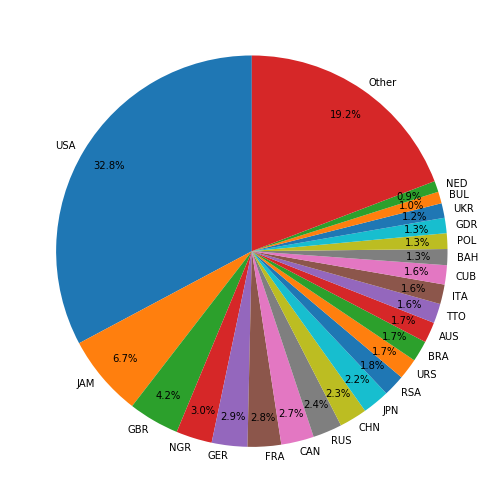

In [14]:
# create ranking
df1natcount=df1_preprocessed['Nat'].value_counts()
df1natcount_above=df1natcount[df1natcount>=30]
df1natcount_below=pd.Series([len(df1.index)-df1natcount_above.sum()],index=['Other'])
df1natcount_final=df1natcount_above.append(df1natcount_below)

# plot
plt.figure(figsize=(9,9))
df1natcount_final.plot(kind='pie', autopct='%1.1f%%', pctdistance=0.85, labeldistance=1.05, startangle=90, shadow=False, legend = False, fontsize=10)

plt.axis('off')
plt.show()

### II. Distribution of Age at PB

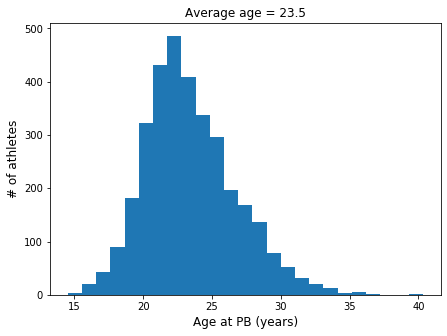

In [15]:
# exclude NaNs by requiring Age>0
df1_ages = df1_preprocessed[df1_preprocessed['Age at PB']>0]['Age at PB']

plt.figure(figsize=(7,5))
plt.hist(df1_ages, bins=25)
plt.title('Average age = %.1f' % df1_ages.mean(), size=12)
plt.xlabel('Age at PB (years)', size=12)
plt.ylabel('# of athletes', size=12)
plt.show()

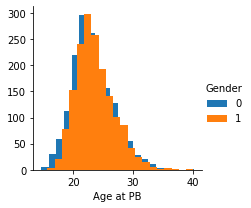

In [16]:
g = sns.FacetGrid(data=df1_preprocessed[df1_preprocessed['Age at PB']>0],hue='Gender')
g.map(plt.hist,'Age at PB',bins=20)
g.add_legend()

We observe that the two histograms are essentially identical.

### III. Youngest and oldest in the all-time lists ###

In [17]:
df1_preprocessed.iloc[[df1_ages.idxmin()]]

,Rank,100m,WIND,Competitor,DOB,Nat,Pos,Venue,Date,Results Score,Gender,Age at PB,JAM,USA
2765,1031,11.37,1.7,Tia CLAYTON,17 AUG 2004,JAM,1,Spanish Town (JAM),26 FEB 2019,1120,0,14.527036,1,0


In [18]:
df1_preprocessed.iloc[[df1_ages.idxmax()]]

,Rank,100m,WIND,Competitor,DOB,Nat,Pos,Venue,Date,Results Score,Gender,Age at PB,JAM,USA
2078,371,11.18,1.0,Irina KHABAROVA,18 MAR 1966,RUS,1,Tula (RUS),15 JUL 2006,1161,0,40.325804,0,0


### IV. Years with most PBs ###

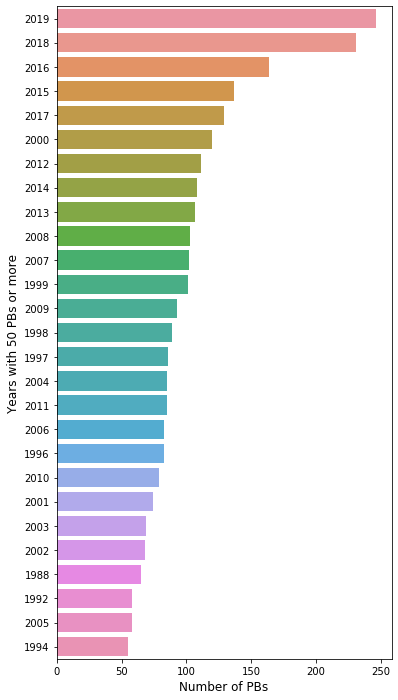

In [19]:
df1_preprocessed['Year of PB'] = pd.to_datetime(df1_preprocessed['Date']).dt.year
df1_yearcount = df1_preprocessed['Year of PB'].value_counts()
df1_yearcountfinal_index = df1_yearcount[df1_yearcount>=50].index

# plot
plt.figure(figsize=(6,12))
sns.countplot(y='Year of PB', data=df1_preprocessed[df1_preprocessed['Year of PB'].isin(df1_yearcountfinal_index)], order=df1_yearcountfinal_index)
plt.xlabel('Number of PBs', size=12)
plt.ylabel('Years with 50 PBs or more', size=12)
plt.show()

### V. Venues with most PBs ###

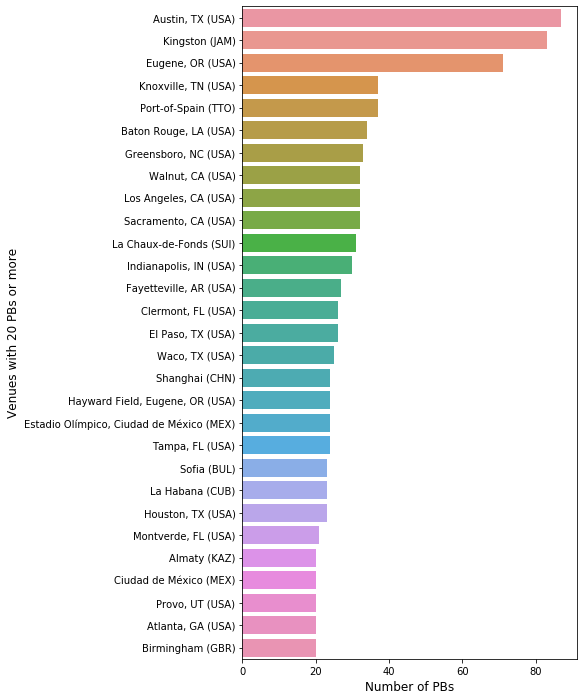

In [20]:
df1_venuecount = df1_preprocessed['Venue'].value_counts()
df1_venuecountfinal_index = df1_venuecount[df1_venuecount>=20].index

# plot
plt.figure(figsize=(6,12))
sns.countplot(y='Venue', data=df1_preprocessed[df1_preprocessed['Venue'].isin(df1_venuecountfinal_index)], order=df1_venuecountfinal_index)
plt.xlabel('Number of PBs', size=12)
plt.ylabel('Venues with 20 PBs or more', size=12)
plt.show()

### VI. Correlation between features

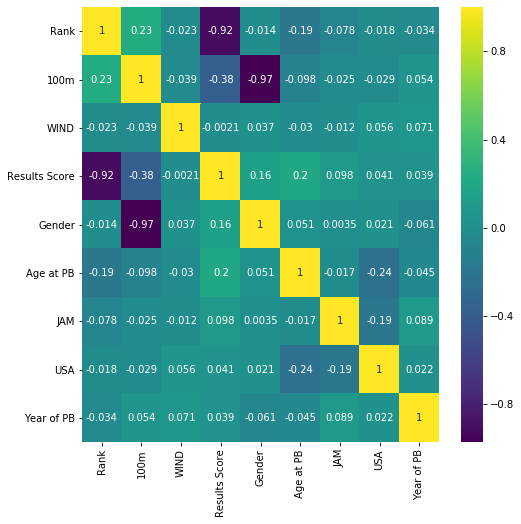

In [21]:
plt.figure(figsize=(8,8))
sns.heatmap(df1_preprocessed.corr(),annot=True,cmap='viridis')
plt.show()

The behavior is as expected. By definition, the Results Score is highly anti-correlated with the Rank (highest score gives you rank #1 in the all-time list). Gender is also highly anti-correlated with the 100m mark as women (gender 0) have higher 100m PBs while men (gender 1) have lower 100m PBs. Naturally, Results Score and 100m PBs would be highly anti-correlated for each gender separately but since we include both in the same dataset the anti-correlation is smaller.

### VII. World records for 100m men 1st-6th finish ###

(cell below might take a while since it's webscraping the dataset)

In [22]:
# need list with ALL results (not only 'best by athlete')
df_to_concat_100m_all_list = []

npage=10
ip=1
while ip<=npage:
    one_page_read = pd.read_html('http://www.worldathletics.org/records/all-time-toplists/sprints/100-metres/outdoor/men/senior?regionType=world&timing=electronic&windReading=regular&page=' + str(ip) + '&bestResultsOnly=false&firstDay=1899-12-31&lastDay=' + datetime.today().strftime('%Y-%m-%d'))
    df_to_concat_100m_all_list.append(one_page_read[0])
    ip+=1
    
df3 = pd.concat(df_to_concat_100m_all_list, ignore_index=True)

In [23]:
# get positions inside dataframe
df3_pos=df3['Pos']

df3_posfinishindex = []

ipos=1
while ipos<=6:

    # determine first occurrence of ipos in dateframe and save its position
    df3_pos_tmpindex=df3_pos[df3_pos.str.startswith(str(ipos))==True].index[0]
    df3_posfinishindex.append(df3_pos_tmpindex)
    
    # handle cases where there is a tie
    ipos_tie=1
    df3_pos_tmpindex_tie=df3_pos[df3_pos.str.startswith(str(ipos))==True].index[ipos_tie]
    while df3.iloc[df3_pos_tmpindex_tie]['Mark']==df3.iloc[df3_pos_tmpindex]['Mark']:
        df3_posfinishindex.append(df3_pos_tmpindex_tie)
        ipos_tie+=1
        df3_pos_tmpindex_tie=df3_pos[df3_pos.str.startswith(str(ipos))==True].index[ipos_tie]
    
    ipos+=1

# print out info
df3.drop('Unnamed: 7',axis=1).iloc[df3_posfinishindex]

,Rank,Mark,WIND,Competitor,DOB,Nat,Pos,Venue,Date,Results Score
0,1,9.58,0.9,Usain BOLT,21 AUG 1986,JAM,1,"Olympiastadion, Berlin (GER)",16 AUG 2009,1356
5,6,9.71,0.9,Tyson GAY,09 AUG 1982,USA,2,"Olympiastadion, Berlin (GER)",16 AUG 2009,1308
39,35,9.79,1.5,Justin GATLIN,10 FEB 1982,USA,3,"Olympic Stadium, London (GBR)",05 AUG 2012,1280
178,160,9.88,1.5,Ryan BAILEY,13 APR 1989,USA,4,"Olympic Stadium, London (GBR)",05 AUG 2012,1248
365,337,9.93,0.9,Richard THOMPSON,07 JUN 1985,TTO,5,"Olympiastadion, Berlin (GER)",16 AUG 2009,1231
552,547,9.96,1.2,Raymond STEWART,18 MAR 1965,JAM,6,"Olympic Stadium, Tokyo (JPN)",25 AUG 1991,1220
627,547,9.96,0.2,Ben Youssef MEITÉ,11 NOV 1986,CIV,6,"Estádio Olímpico, Rio de Janeiro (BRA)",14 AUG 2016,1220


## Merge 100m-200m list.  Want to construct a regression model that predicts an athlete's 200m PB based on their 100m PB, age at 100m PB, gender, and nationality

In [24]:
# merge on name and DOB to handle athletes with same names but different DOBs
df4=pd.merge(df1_preprocessed[['Competitor','DOB','Gender','Age at PB','JAM','USA','100m','Date']],
             df2[['Competitor','DOB','200m','Date']], on=['Competitor','DOB'])
df4.rename(columns={'Age at PB':'Age at 100m PB'}, inplace=True)

In [25]:
df4.head()

,Competitor,DOB,Gender,Age at 100m PB,JAM,USA,100m,Date_x,200m,Date_y
0,Usain BOLT,21 AUG 1986,1,22.986995,1,0,9.58,16 AUG 2009,19.19,20 AUG 2009
1,Tyson GAY,09 AUG 1982,1,27.115674,0,1,9.69,20 SEP 2009,19.58,30 MAY 2009
2,Yohan BLAKE,26 DEC 1989,1,22.658453,1,0,9.69,23 AUG 2012,19.26,16 SEP 2011
3,Asafa POWELL,23 NOV 1982,1,25.776865,1,0,9.72,02 SEP 2008,19.90,25 JUN 2006
4,Justin GATLIN,10 FEB 1982,1,33.256674,0,1,9.74,15 MAY 2015,19.57,28 JUN 2015


### Filter data  
We keep only observations where 100m and 200m PBs were obtained less than 5 years apart to improve predicting power of the model

In [26]:
# convert dates to date format
df4['Date_x']=pd.to_datetime(df4['Date_x'])
df4['Date_y']=pd.to_datetime(df4['Date_y'])

# take difference between 100m and 200m PB dates
df4['DeltaT']=abs(df4['Date_x']-df4['Date_y'])

# filter data: keep only entries where 100m and 200m PBs were obtained less than 5 years apart
df4_final=df4[df4['DeltaT']<'1825 days'].copy()

Size of the final dataset

In [27]:
len(df4_final)

1802

### Final pre-processing : substitute NaNs in 'Age at 100m PB' with average age

In [28]:
fill_age_value = {'Age at 100m PB': df4_final['Age at 100m PB'].mean()}
df4_final.fillna(fill_age_value,inplace=True)

## Linear Regression using scikit-learn

### Create inputs and target

In [29]:
X = df4_final[['100m','Age at 100m PB','Gender','JAM','USA']]
y = df4_final['200m']

### Standardize numerical features

In [30]:
scaled_X = X.copy()
features = scaled_X[['100m', 'Age at 100m PB']]

scaler = StandardScaler()
scaler.fit(features.values)
features = scaler.transform(features.values)
scaled_X[['100m', 'Age at 100m PB']] = features

In [31]:
scaled_X.head()

,100m,Age at 100m PB,Gender,JAM,USA
0,-2.016439,-0.214356,1,1,0
1,-1.823380,1.098800,1,0,1
2,-1.823380,-0.318851,1,1,0
3,-1.770728,0.672982,1,1,0
4,-1.735627,3.051988,1,0,1


### Train-test split (80-20)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=42)

### Perform regression

In [33]:
reg = LinearRegression()
reg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [34]:
# predictions
y_hat = reg.predict(X_train)

In [35]:
# get R-squared and adjusted R-squared of train sample
R2_train=reg.score(X_train,y_train)
adj_R2_train=1-(1-R2_train)*(X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)
print ('R2_train = ',R2_train)
print ('adj_R2_train = ',adj_R2_train)

# get intercept
const=reg.intercept_
print ('intercept = ',const)

# get weights
reg_summary = pd.DataFrame(scaled_X.columns.values, columns=['Features'])
reg_summary['Weights'] = reg.coef_
reg_summary

R2_train =  0.9600022015252779
adj_R2_train =  0.9598628363737981
intercept =  22.185438614510552


,Features,Weights
0,100m,0.781864
1,Age at 100m PB,-0.022420
2,Gender,-0.976281
3,JAM,-0.010925
4,USA,-0.030778


By looking at the weights we can extract very interesting information. First of all, 'Age at 100m PB' has essentially no impact in predicting the 200m PB of an athlete. The same is true for the nationality. Being either American or Jamaican reduces an athlete's predicted 200m PB only by 1-3/100 of a second. On the other hand, an athlete's 100m PB and gender play very big roles, as expected. The impact of the 100m PB is hard to interpret because we standardized this feature, while the impact of gender is easier to understand. More specifically, it is predicted that being male reduces an athlete's 200m PB by approx one second (without even considering the athlete's 100m PB). Finally, we could do backward elimination and eliminate nationality and age from our set of features and repeat the regression but it is likely that the result would not change much.

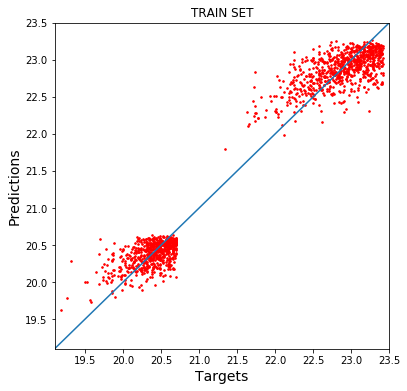

In [36]:
plt.figure(figsize=(6,6))
plt.scatter(y_train, y_hat, 10, marker='.', c='r')
plt.xlabel('Targets',size=14)
plt.ylabel('Predictions',size=14)
plt.xlim(19.1,23.5)
plt.ylim(19.1,23.5)
plt.title('TRAIN SET')
_ = plt.plot([19.1,23.5],[19.1,23.5])
plt.show()

Text(0.5, 1.0, 'Train residuals PDF')

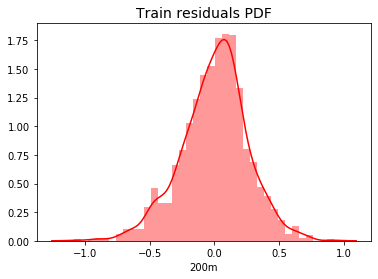

In [37]:
sns.distplot(y_train - y_hat,color='r')
plt.title("Train residuals PDF", size=14)

We observe normal behavior for the distribution of the residuals of the train set. Since the peak of the distribution is slightly greater than zero, we can say that the regression predicts 200m PBs slightly lower than the true values.

### Testing

In [38]:
y_hat_test = reg.predict(X_test)

R2_test=reg.score(X_test,y_test)
adj_R2_test=1-(1-R2_test)*(X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)
print ('R2_test = ',R2_test)
print ('adj_R2_test = ',adj_R2_test)

R2_test =  0.9646503715915118
adj_R2_test =  0.9641524895012514


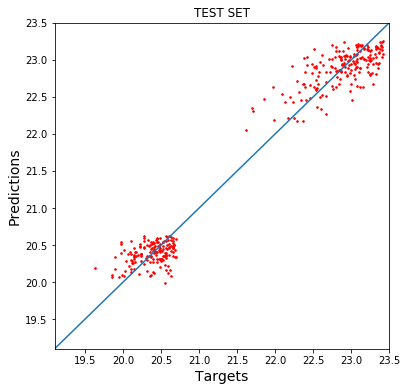

In [39]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_hat_test, 10, marker='.', c='r')
plt.xlabel('Targets',size=14)
plt.ylabel('Predictions',size=14)
plt.xlim(19.1,23.5)
plt.ylim(19.1,23.5)
plt.title('TEST SET')
_ = plt.plot([19.1,23.5],[19.1,23.5])
plt.show()

Text(0.5, 1.0, 'Test residuals PDF')

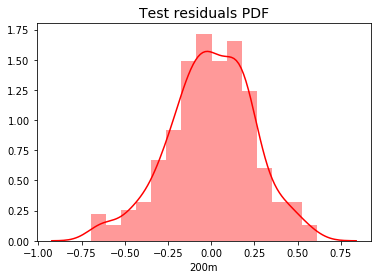

In [40]:
sns.distplot(y_test - y_hat_test, color='r')
plt.title("Test residuals PDF", size=14)

## Neural Network using TensorFlow 2

### Further split train set into train and validation sets. Overall split: 64 (train) - 16 (val) - 20 (test)

In [41]:
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Convert dataframes into numpy arrays for tensorflow

In [42]:
# train
train_inputs, train_target = X_train_nn.values, y_train_nn.values
# validation
validation_inputs, validation_target = X_val_nn.values, y_val_nn.values
# test
test_inputs, test_target = X_test.values, y_test.values

### Define and train neural network
Outline of the network:  
1. Two hidden layers with 64 nodes each. We choose sigmoid for the 1st layer and relu for the 2nd layer to probe the possible non-linearity of this regression
2. We choose adam as the optimizer  
3. We choose logcosh as the loss function to reduce the impact of outliers (in general, track and field performances can depend on many unpredictable factors so outliers are to be expected but the regression shouldn't depend heavily on them in our opinion)
4. We are interested in MAE as a metric for the regression accuracy
5. We use a validation set with early stopping (with patience=2) to prevent overfitting of the train set  
6. Finally, we fix the batch size to be 100 and the max number of epochs to be 300

In [43]:
input_size = 5
output_size = 1

hidden_layer_size = 64

model = tf.keras.Sequential([
    tf.keras.layers.Dense(hidden_layer_size, activation='sigmoid'), # 1st hidden layer
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 2nd hidden layer
    tf.keras.layers.Dense(output_size) # output layer
])

model.compile(optimizer='adam', loss='logcosh', metrics=['mae'])

batch_size = 100
max_epochs = 300

early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)

model.fit(train_inputs,
          train_target,
          batch_size=batch_size,
          epochs=max_epochs,
          callbacks=[early_stopping],
          validation_data=(validation_inputs, validation_target),
          verbose = 2
          )  

Train on 1152 samples, validate on 289 samples
Epoch 1/300
1152/1152 - 1s - loss: 19.1925 - mae: 19.8857 - val_loss: 18.1359 - val_mae: 18.8291
Epoch 2/300
1152/1152 - 0s - loss: 17.3323 - mae: 18.0255 - val_loss: 16.1527 - val_mae: 16.8459
Epoch 3/300
1152/1152 - 0s - loss: 15.2383 - mae: 15.9314 - val_loss: 13.8697 - val_mae: 14.5629
Epoch 4/300
1152/1152 - 0s - loss: 12.7605 - mae: 13.4536 - val_loss: 11.1240 - val_mae: 11.8171
Epoch 5/300
1152/1152 - 0s - loss: 9.7851 - mae: 10.4782 - val_loss: 7.8384 - val_mae: 8.5316
Epoch 6/300
1152/1152 - 0s - loss: 6.2404 - mae: 6.9335 - val_loss: 3.9492 - val_mae: 4.6408
Epoch 7/300
1152/1152 - 0s - loss: 2.3052 - mae: 2.9177 - val_loss: 0.9714 - val_mae: 1.5975
Epoch 8/300
1152/1152 - 0s - loss: 0.9266 - mae: 1.4664 - val_loss: 0.9960 - val_mae: 1.4839
Epoch 9/300
1152/1152 - 0s - loss: 0.7191 - mae: 1.2051 - val_loss: 0.5091 - val_mae: 1.0565
Epoch 10/300
1152/1152 - 0s - loss: 0.4360 - mae: 0.9385 - val_loss: 0.3397 - val_mae: 0.7990
Epoch

### Testing

In [44]:
loss, mae = model.evaluate(test_inputs,test_target,verbose=2)
print("Test Set MAE: {:5.2f}".format(mae))

361/1 - 0s - loss: 0.0469 - mae: 0.2274
Test Set MAE:  0.23


In [45]:
y_hat_test_nn = model.predict(test_inputs).flatten()

In [46]:
R2_test_nn = r2_score(test_target, y_hat_test_nn)
adj_R2_test_nn=1-(1-R2_test_nn)*(len(test_inputs)-1)/(len(test_inputs)-input_size-1)

print ('R2_test_nn = ',R2_test_nn)
print ('adj_R2_test_nn = ',adj_R2_test_nn)

R2_test_nn =  0.9479360800328712
adj_R2_test_nn =  0.9472027853854469


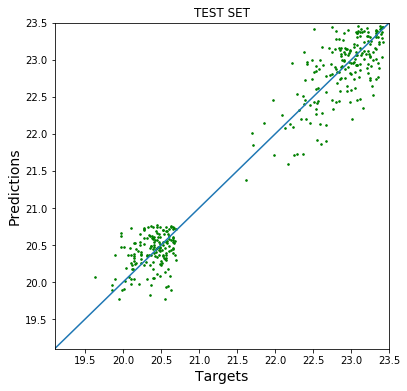

In [47]:
plt.figure(figsize=(6,6))
plt.scatter(test_target, y_hat_test_nn, 10, marker='.', c='g')
plt.xlabel('Targets',size=14)
plt.ylabel('Predictions',size=14)
plt.xlim(19.1,23.5)
plt.ylim(19.1,23.5)
plt.title('TEST SET')
_ = plt.plot([19.1,23.5],[19.1,23.5])
plt.show()

Text(0.5, 1.0, 'Test residuals PDF')

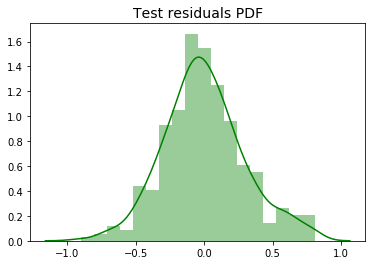

In [48]:
sns.distplot(test_target - y_hat_test_nn, color='g')
plt.title("Test residuals PDF", size=14)

## Comparison between Linear Regression and Neural Network

In [49]:
# difference (%) between truth and predictions for test set for LR
LRdiff=100*(y_test-y_hat_test)/y_test

# difference (%) between truth and predictions for test set for NN
NNdiff=100*(test_target-y_hat_test_nn)/test_target

# MAPE of test set for LR
LRmape=np.mean(np.abs(LRdiff))

# MAPE of test set for NN
NNmape=np.mean(np.abs(NNdiff))

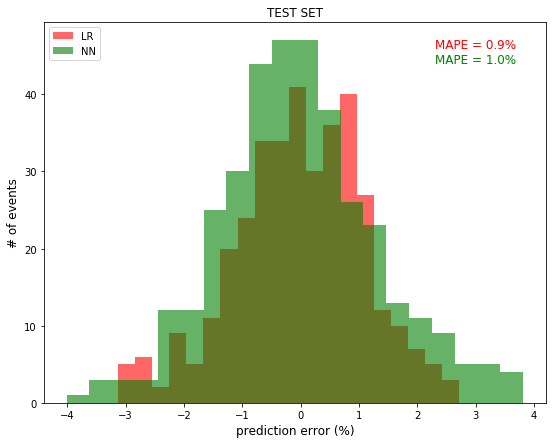

In [50]:
plt.figure(figsize=(9,7))
plt.hist(LRdiff, bins=20, alpha=0.6, label='LR', color='red')
plt.hist(NNdiff, bins=20, alpha=0.6, label='NN', color='green')
plt.legend(loc='upper left')
plt.title('TEST SET', size=12)
plt.xlabel('prediction error (%)', size=12)
plt.ylabel('# of events', size=12)

plt.text(2.3,46,'MAPE = %.1f' % LRmape + '%', size=12, color='red')
plt.text(2.3,44,'MAPE = %.1f' % NNmape + '%', size=12, color='green')

plt.show()

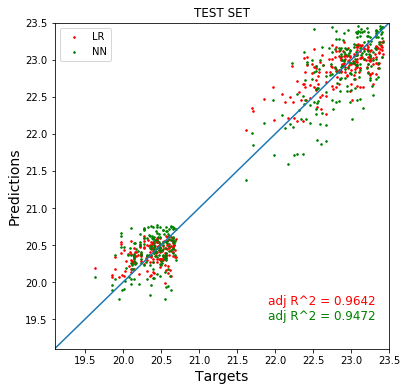

In [51]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_hat_test, 10, marker='.', c='r', label='LR')
plt.scatter(test_target, y_hat_test_nn, 10, marker='.', c='g', label='NN')

plt.xlabel('Targets',size=14)
plt.ylabel('Predictions',size=14)
plt.xlim(19.1,23.5)
plt.ylim(19.1,23.5)
plt.title('TEST SET')

plt.text(21.9,19.70,'adj R^2 = %.4f' % adj_R2_test, size=12, color='red')
plt.text(21.9,19.50,'adj R^2 = %.4f' % adj_R2_test_nn, size=12, color='green')

plt.legend(loc='upper left')
_ = plt.plot([19.1,23.5],[19.1,23.5])
plt.show()

## References ###  
[1] https://github.com/srcole/insightfellows for ideas for the sns countplots    
[2] official documentation of scikit-learn, pandas, tensorflow, etc  
[3] Stackoverflow